In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from pylab import plot,show, hist, rcParams 
rcParams['figure.figsize'] = 12, 5

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

### Домашние задание

Имеются данные adult.csv (см. в материалах к занятию или на гитхабе).
Целевой переменной является уровень дохода income (крайний правый столбец).
Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.

### Решение

terget = `income`. нам надо предсказывать доход человека больше 50к или меньше/равно 50к,
в нашем наборе данных признак income имеет порядковые значение, соответственно для решения задачи классификации мы выполним бинаризацию данных

In [2]:
#загрузим данные
data = pd.read_csv('adult.csv')

In [3]:
#посмотрим сколько обьектов и признаков
data.shape

(48842, 15)

In [4]:
#посмотрим какие есть признаки
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [5]:
#посмотрим наши данные
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [6]:
#посмотрим на типы данных 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


В нашем наброе данных 9 категориальных признаков, давайте посмотрим на них и проверим есть ли среди них странные/пропущенные данные

In [7]:
data['workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [8]:
data['education'].unique()

array(['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th',
       'Prof-school', '7th-8th', 'Bachelors', 'Masters', 'Doctorate',
       '5th-6th', 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool'],
      dtype=object)

In [9]:
data['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [10]:
data['occupation'].unique()

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [11]:
data['relationship'].unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [12]:
data['race'].unique()

array(['Black', 'White', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [13]:
data['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [14]:
data['native-country'].unique()

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

In [15]:
data['income'].unique()

array(['<=50K', '>50K'], dtype=object)

У нас есть три категориальных признака, где имеются пропущенные значения `workclass`, `occupation` и `native-country`. Давайте посмотрим какую долю от общего кол-ва состовляют пропущенные данные

In [16]:
data[data['workclass'] == '?'].count()

age                2799
workclass          2799
fnlwgt             2799
education          2799
educational-num    2799
marital-status     2799
occupation         2799
relationship       2799
race               2799
gender             2799
capital-gain       2799
capital-loss       2799
hours-per-week     2799
native-country     2799
income             2799
dtype: int64

In [17]:
data[data['occupation'] == '?'].count()

age                2809
workclass          2809
fnlwgt             2809
education          2809
educational-num    2809
marital-status     2809
occupation         2809
relationship       2809
race               2809
gender             2809
capital-gain       2809
capital-loss       2809
hours-per-week     2809
native-country     2809
income             2809
dtype: int64

In [18]:
data[data['native-country'] == '?'].count()

age                857
workclass          857
fnlwgt             857
education          857
educational-num    857
marital-status     857
occupation         857
relationship       857
race               857
gender             857
capital-gain       857
capital-loss       857
hours-per-week     857
native-country     857
income             857
dtype: int64

Пропущенные данные:
- workclass = 2799
- occupation = 2809
- native-country = 857

Выберем стратегию, что делать с пропущенными данными, для начала посмотрим на распределение категориальных признаков внутри каждой фичи

- workclass

In [19]:
data['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [20]:
len(data[data['workclass']=='?']) / len(data) * 100

5.7307235575938735

Можно выделить один мажоритарных класс `Private`, соответственно попробуем пропущенные данные заменить на значение `Private`

- occupation

In [21]:
data['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [22]:
len(data[data['occupation']=='?']) / len(data) * 100

5.751197739650301

Можно выделить сразу 5 мажоритарных классов, соответственно заполнять пропущенные данные каким-либо наиболее часто встречающимся значение не получится, также исключить обьекты с пропусками нецелесообразно потому, что они составляют 5.7% данной фичи, значит для данного признака все пропущенные данные заменим значением `missed`

- native-country

In [23]:
data['native-country'].value_counts().head(7)

United-States    43832
Mexico             951
?                  857
Philippines        295
Germany            206
Puerto-Rico        184
Canada             182
Name: native-country, dtype: int64

In [24]:
len(data[data['native-country']=='?']) / len(data) * 100

1.7546374022357807

Можно выделить один мажоритарных класс `United-States`, соответственно попробуем пропущенные данные заменить на значение `Private`

### Выполнем преобразование пропущенных данных

In [25]:
data.loc[data.workclass == '?', 'workclass'] = 'Private'
data['workclass'].unique()

array(['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [26]:
data.loc[data.occupation == '?', 'occupation'] = 'Missed'
data['occupation'].unique()

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv',
       'Missed', 'Other-service', 'Prof-specialty', 'Craft-repair',
       'Adm-clerical', 'Exec-managerial', 'Tech-support', 'Sales',
       'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners',
       'Armed-Forces'], dtype=object)

In [27]:
data.loc[data['native-country'] == '?', 'native-country'] = 'United-States'
data['native-country'].unique()

array(['United-States', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

### Выполним так сказать эксплоративный анализ данных, посмотрим на распределение данных

Посмотрим на распределение нашего таргета

In [28]:
data['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [29]:
count_no_sub = len(data[data['income']=='<=50K'])
count_sub = len(data[data['income']=='>50K'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Доля дохода меньше или равная 50к", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Доля дохода больше 50к", pct_of_sub*100)

Доля дохода меньше или равная 50к 76.07182343065395
Доля дохода больше 50к 23.928176569346054


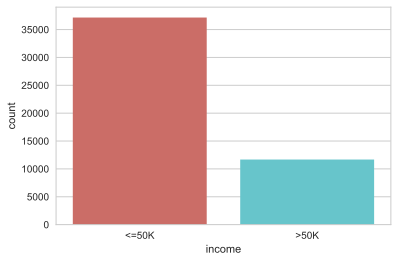

In [30]:
sns.countplot(x = 'income', data=data, palette='hls')
plt.show()

В нашем наборе данных серьезный дисбаланс кол-ва обьектов с целевой переменной, соощественно придется подумать насчет оверсемпла или андерсемпла

Посмотрим распределение уровня дохода по типу работадателя `workclass`

Text(0,0.5,'Кол-во обьектов')

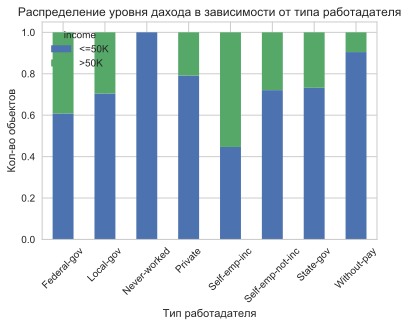

In [31]:
table=pd.crosstab(data.workclass,data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=45)
plt.title('Распределение уровня дахода в зависимости от типа работадателя')
plt.xlabel('Тип работадателя')
plt.ylabel('Кол-во обьектов')

Можно наблюдать достаточно интересное распределение, мы видим что категория `Never-worked` всегда имеет доход равный или менше 50к, тип `Private` также имеет существенную разницу между кол-вом значения целевой переменной. Данный признок может иметь достаточно серьезный обучающий потенциал

Text(0,0.5,'Кол-во обьектов')

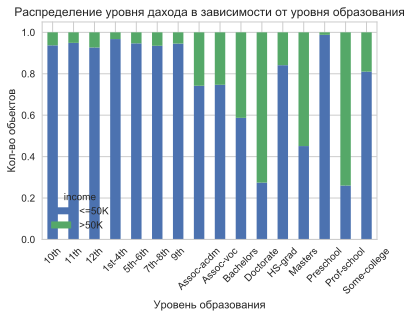

In [32]:
table=pd.crosstab(data.education,data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=45)
plt.title('Распределение уровня дахода в зависимости от уровня образования')
plt.xlabel('Уровень образования')
plt.ylabel('Кол-во обьектов')

В перспективе возможно есть смысл генерации новых фичей, новый категориальный признак высшее образование и среднее образование

Text(0,0.5,'Кол-во обьектов')

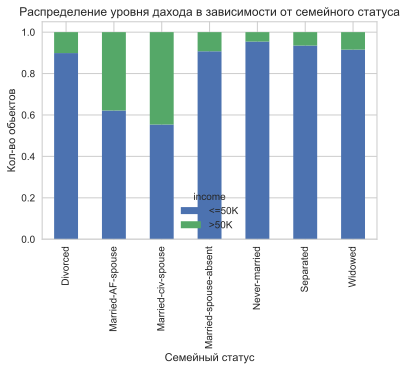

In [33]:
table=pd.crosstab(data['marital-status'],data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Распределение уровня дахода в зависимости от семейного статуса')
plt.xlabel('Семейный статус')
plt.ylabel('Кол-во обьектов')

Очень интересно, оказывается что наличие супруга/супруги влияет на уровень дохода. В нашей выборке соотношение уровня дохода близкое к 50% имееют только замужние/женатые 

Давайте посмотрим на распределение образования и семейного статуса

Text(0,0.5,'Кол-во обьектов')

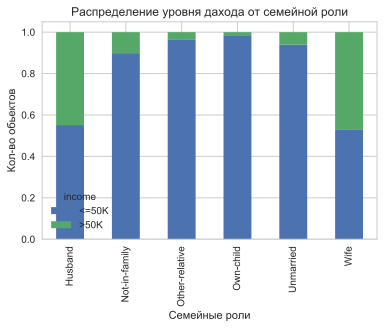

In [34]:
table=pd.crosstab(data.relationship,data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Распределение уровня дахода от семейной роли')
plt.xlabel('Семейные роли')
plt.ylabel('Кол-во обьектов')

Мне кажется из данного признака может получится отличная новая фича

Давайте посмотрим на распределение дохода и расы

Text(0,0.5,'Кол-во обьектов')

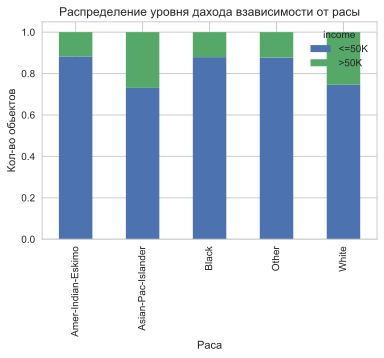

In [35]:
table=pd.crosstab(data.race,data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Распределение уровня дахода взависимости от расы')
plt.xlabel('Раса')
plt.ylabel('Кол-во обьектов')

что-то значимое из данного распределения отметить сложно

Давайте посмотрим на распределение дохода и типа занятости

Text(0,0.5,'Кол-во обьектов')

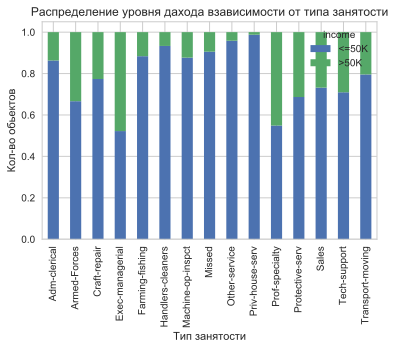

In [36]:
table=pd.crosstab(data.occupation,data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Распределение уровня дахода взависимости от типа занятости')
plt.xlabel('Тип занятости')
plt.ylabel('Кол-во обьектов')

Давайте посмотрим на распределение дохода и пола

Text(0,0.5,'Кол-во обьектов')

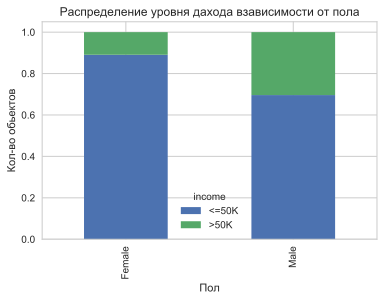

In [37]:
table=pd.crosstab(data.gender,data.income)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Распределение уровня дахода взависимости от пола')
plt.xlabel('Пол')
plt.ylabel('Кол-во обьектов')

###  Часть 1 (отберем в набор данных 7 признаков и будем работать с ними)

### Подготовим данные для модели

Выберем признаки которые будем использовать, а также те признаки, которые мы будем трансформировать из категориальных в бинарные

Выберем основные признаки на которых будем обучаться:
- age
- hours-per-week
- workclass
- education
- occupation
- marital-status
- relationship

признаки выбранны экспертно на основе анализа распределений приведенных выше

In [38]:
selected_columns = data[ ['age', 'hours-per-week', 'workclass', 'education', \
                                                                      'occupation', 'marital-status', 'relationship'] ]

In [39]:
X = pd.get_dummies(selected_columns, columns = ['workclass', 'education', 'occupation', 'marital-status', 'relationship'])
X.head()#преобразование в числа (меняем размерность)

,age,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,25,40,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,38,50,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,28,40,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,44,40,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,18,30,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [40]:
X.shape

(48842, 54)

In [41]:
#создадим список со значениями нашего таргета
target = data['income']

Выполним бинаризацию целевого признака

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [43]:
#зафитим наш таргет
le.fit(target)

LabelEncoder()

In [44]:
y = pd.Series(le.transform(data['income']))

### Разделим наш набор данных на трейн и тест

In [45]:
from sklearn.model_selection import train_test_split, cross_val_score

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3)

### Строим модель (Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=i)
    logreg.fit(X_train, Y_train)
    
    print('Номер эксперемента (итерации разбиения выборки): {:.0f}'.format(i))
    print('Результата на трейне : {:.4f}'.format(logreg.score(X_train, Y_train)))  
    print('Результата на тесте : {:.4f}'.format(logreg.score(X_test, Y_test)))

Номер эксперемента (итерации разбиения выборки): 0
Результата на трейне : 0.8351
Результата на тесте : 0.8346
Номер эксперемента (итерации разбиения выборки): 1
Результата на трейне : 0.8349
Результата на тесте : 0.8357
Номер эксперемента (итерации разбиения выборки): 2
Результата на трейне : 0.8343
Результата на тесте : 0.8358
Номер эксперемента (итерации разбиения выборки): 3
Результата на трейне : 0.8349
Результата на тесте : 0.8367
Номер эксперемента (итерации разбиения выборки): 4
Результата на трейне : 0.8361
Результата на тесте : 0.8352
Номер эксперемента (итерации разбиения выборки): 5
Результата на трейне : 0.8362
Результата на тесте : 0.8321


## В продолжение нашего разговора на лекции (про результат на тесте выше чем на трейне) я протестил ваше решение и вот что получилось, из 6 разных разбивок выборки на 3 я стабильно получаю результат на трейне выше чем на тесте.

In [56]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
y_pred_1 = logreg.predict(X_train)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_train, Y_train)))

Accuracy of logistic regression classifier on test set: 0.8353


In [58]:
from sklearn.metrics import classification_report
print(classification_report(Y_train, y_pred_1))

             precision    recall  f1-score   support

          0       0.87      0.92      0.90     26020
          1       0.69      0.56      0.62      8169

avg / total       0.83      0.84      0.83     34189



In [60]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.8385


In [61]:
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.92      0.90     11142
          1       0.70      0.57      0.63      3511

avg / total       0.83      0.84      0.83     14653



Давайте снова разобьем наши данные и выполним кросс-валидацию и посмотрим что будет

In [66]:
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X, y, test_size = 0.3)

In [68]:
new_logreg = LogisticRegression()

In [69]:
cross_val_score(new_logreg, X_train_cv, Y_train_cv, cv=5)

array([0.83696447, 0.83796432, 0.830506  , 0.83194384, 0.83033494])

In [70]:
np.mean(cross_val_score(new_logreg, X_train_cv, Y_train_cv, cv=5))

0.833542711737606

а что будет если мы возьмем и выполнем кросс валидацию на трейне который мы тестили выше на соотношении 70% на 30%

In [72]:
np.mean(cross_val_score(logreg, X_train, Y_train))

0.8336307047810075

результаты очень близки.

##### Ради эксперемента попробовал протестировать данные на моделе которая использует алгоритм  SVM

In [77]:
X_train_svm, X_test_svm, Y_train_svm, Y_test_svm = train_test_split(X, y, test_size = 0.3, random_state = 1)

Тестируем на трейне

In [78]:
from sklearn import metrics
from sklearn.svm import SVC
# fit a SVM model to the data
model = SVC()
model.fit(X_train_svm, Y_train_svm)
print(model)
# make predictions
expected = Y_train_svm
predicted = model.predict(X_train_svm)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.86      0.93      0.90     26043
          1       0.71      0.53      0.61      8146

avg / total       0.83      0.84      0.83     34189

[[24309  1734]
 [ 3800  4346]]


In [79]:
y_pred_svm = model.predict(X_train_svm)
print('Accuracy of SVM classifier on test set: {:.4f}'.format(model.score(X_train_svm, Y_train_svm)))

Accuracy of SVM classifier on test set: 0.8381


Тестируем на тесте

In [80]:
model = SVC()
model.fit(X_test_svm, Y_test_svm)
print(model)

expected = Y_test_svm
predicted = model.predict(X_test_svm)

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.86      0.94      0.90     11112
          1       0.72      0.52      0.60      3541

avg / total       0.83      0.84      0.83     14653

[[10402   710]
 [ 1706  1835]]


In [81]:
y_pred_svm = model.predict(X_test_svm)
print('Accuracy of SVM classifier on test set: {:.4f}'.format(model.score(X_test_svm, Y_test_svm)))

Accuracy of SVM classifier on test set: 0.8351


###  Часть 2 (отберем в набор данных 10 признаков и будем работать с ними)

### Подготовим данные для модели

Выберем признаки которые будем использовать а также те признаки которые мы будем трансформировать из категориальных в бинарные

Выберем основные признаки на которых будем обучаться:
- age
- hours-per-week
- workclass
- education
- educational-num
- gender
- native-country
- occupation
- marital-status
- relationship

признаки выбранны экспертно на основе анализу распределений приведенных выше

In [88]:
selected_columns_1 = data[['age', 'hours-per-week', 'workclass', 'education', 'educational-num',\
                                            'native-country','gender', 'occupation', 'marital-status', 'relationship']] 

In [113]:
X1 = pd.get_dummies(selected_columns_1, columns = 
                   ['workclass', 'education', 'occupation', 'marital-status', 'relationship',
                    'native-country', 'gender',
                   ])

In [114]:
#создадим список со значениями нашего таргета
target1 = data['income']

In [115]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()

In [116]:
le1.fit(target1)

LabelEncoder()

In [117]:
y1 = pd.Series(le1.transform(data['income']))

### Разделим наш набор данных на трейн и тест

In [118]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size = 0.3)

### Строим модель (Logistic Regression)

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
logreg1 = LogisticRegression()
logreg1.fit(X_train1, Y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [121]:
y_pred_11 = logreg1.predict(X_train1)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg1.score(X_train1, Y_train1)))

Accuracy of logistic regression classifier on test set: 0.8379


In [122]:
y_pred11 = logreg1.predict(X_test1)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg1.score(X_test1, Y_test1)))

Accuracy of logistic regression classifier on test set: 0.8342
